In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})

import os
import re
import pandas as pd
import numpy as np
import shutil
import subprocess
import multiprocessing
import re
import cantera as ct

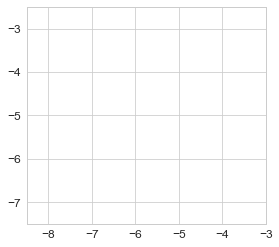

array([[[-8.5   , -8.5   , -8.5   , -8.5   , -8.5   , -8.5   , -8.5   ,
         -8.5   , -8.5   ],
        [-7.8125, -7.8125, -7.8125, -7.8125, -7.8125, -7.8125, -7.8125,
         -7.8125, -7.8125],
        [-7.125 , -7.125 , -7.125 , -7.125 , -7.125 , -7.125 , -7.125 ,
         -7.125 , -7.125 ],
        [-6.4375, -6.4375, -6.4375, -6.4375, -6.4375, -6.4375, -6.4375,
         -6.4375, -6.4375],
        [-5.75  , -5.75  , -5.75  , -5.75  , -5.75  , -5.75  , -5.75  ,
         -5.75  , -5.75  ],
        [-5.0625, -5.0625, -5.0625, -5.0625, -5.0625, -5.0625, -5.0625,
         -5.0625, -5.0625],
        [-4.375 , -4.375 , -4.375 , -4.375 , -4.375 , -4.375 , -4.375 ,
         -4.375 , -4.375 ],
        [-3.6875, -3.6875, -3.6875, -3.6875, -3.6875, -3.6875, -3.6875,
         -3.6875, -3.6875],
        [-3.    , -3.    , -3.    , -3.    , -3.    , -3.    , -3.    ,
         -3.    , -3.    ]],

       [[-7.5   , -6.875 , -6.25  , -5.625 , -5.    , -4.375 , -3.75  ,
         -3.125 , -2.5   ]

In [11]:
carbon_range = (-8.5, -3)
oxygen_range = (-7.5, -2.5)
grid_size = 9
mesh  = np.mgrid[carbon_range[0]:carbon_range[1]:grid_size*1j, 
                 oxygen_range[0]:oxygen_range[1]:grid_size*1j]

with sns.axes_style("whitegrid"):
    plt.axis('square')
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
plt.show()
    
mesh

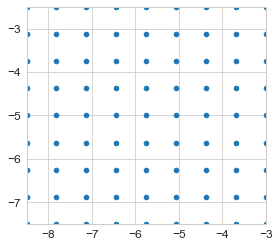

In [12]:
experiments = mesh.reshape((2,-1)).T

with sns.axes_style("whitegrid"):
    plt.axis('square')
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
    plt.plot(*experiments.T, marker='o', linestyle='none')

In [13]:
extent = carbon_range + oxygen_range

# Because the center of a corner pixel is in fact the corner of the grid# Becaus 
# we want to stretch the image a little
c_step = mesh[0,1,0]-mesh[0,0,0]
o_step = mesh[1,0,1]-mesh[1,0,0]
carbon_range2 = (carbon_range[0]-c_step/2, carbon_range[1]+c_step/2)
oxygen_range2 = (oxygen_range[0]-c_step/2, oxygen_range[1]+c_step/2)
extent2 = carbon_range2 + oxygen_range2

In [14]:
from numpy import inf
array = os.listdir('./linearscaling/')
array = sorted(array)
all_ratios=[0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]

# arrays where reach row is a different surface and each column is a c/o ratio
synGasSelec = np.zeros((81,15))
ch4Conversion = np.zeros((81,15))
coSelectivity = np.zeros((81,15))
h2Selectivity = np.zeros((81,15))

count = 0
c_s = []
o_s = []
for x in array:
    _, c, o = x.split("-")
    c = c[:-1]
    c = -1 *float(c)
    o = -1* float(o)
    c_s.append(c)
    o_s.append(o)
    
    try:
        # import data
        conv_sel = pd.read_csv('./linearscaling/'+x+'/dict_conversions_selectivities.csv',header=0)
        
        ratio=[];ch4_conv=[];o2_conv=[];co_selec=[];h2_selec=[];h2o_selec=[];syngas_selec=[]
        for y in range(len(conv_sel.get_values())):
            ratio.append(conv_sel.get_values()[y][1])
            ch4_conv.append(conv_sel.get_values()[y][2])
            o2_conv.append(conv_sel.get_values()[y][3])
            co_selec.append(conv_sel.get_values()[y][4])
            h2_selec.append(conv_sel.get_values()[y][5])
            h2o_selec.append(conv_sel.get_values()[y][6])
            syngas_selec.append(conv_sel.get_values()[y][4]+conv_sel.get_values()[y][5])
    
        ratio = np.round(ratio,1)
        
        # structuring data for syngas volcano plot
        m = zip(ratio,syngas_selec)
        for n in m:
            for r in range(len(all_ratios)):
                p = all_ratios[r]
                if p==n[0]:
                    synGasSelec[count][r] = n[1]
        
        # structuring data for ch4 conversion
        m = zip(ratio,ch4_conv)
        for n in m:
            for r in range(len(all_ratios)):
                p = all_ratios[r]
                if p==n[0]:
                    ch4Conversion[count][r] = n[1]
        
        # structuring data for co selectivity
        m = zip(ratio,co_selec)
        for n in m:
            for r in range(len(all_ratios)):
                p = all_ratios[r]
                if p==n[0]:
                    coSelectivity[count][r] = n[1]
        
        # structuring data for h2 selectivity
        m = zip(ratio,h2_selec)
        for n in m:
            for r in range(len(all_ratios)):
                p = all_ratios[r]
                if p==n[0]:
                    h2Selectivity[count][r] = n[1]
                
    except:
        print("Couldn't find conv/sens csv for {}".format(x))
    
    # assume everything is basically 0, so that's why there are negative conversions
    # and infinite selectivities
    
#     I think I fixed this
#     synGasSelec[synGasSelec == inf] = 0
#     ch4Conversion[ch4Conversion == inf] = 0
#     coSelectivity[coSelectivity == inf] = 0
#     h2Selectivity[h2Selectivity == inf] = 0

    count += 1

Couldn't find conv/sens csv for c-5.062o-7.500
Couldn't find conv/sens csv for c-5.750o-7.500
Couldn't find conv/sens csv for c-6.438o-6.875
Couldn't find conv/sens csv for c-7.125o-7.500
Couldn't find conv/sens csv for c-7.812o-6.875
Couldn't find conv/sens csv for c-7.812o-7.500
Couldn't find conv/sens csv for c-8.500o-6.250
Couldn't find conv/sens csv for c-8.500o-6.875
Couldn't find conv/sens csv for c-8.500o-7.500


In [18]:
# For close packed surfaces from
# Abild-Pedersen, F.; Greeley, J.; Studt, F.; Rossmeisl, J.; Munter, T. R.; Moses, P. G.; Skúlason, E.; Bligaard, T.; Norskov, J. K. Scaling Properties of Adsorption Energies for Hydrogen-Containing Molecules on Transition-Metal Surfaces. Phys. Rev. Lett. 2007, 99 (1), 016105 DOI: 10.1103/PhysRevLett.99.016105.
abildpedersen_energies = { # Carbon, then Oxygen
'Ru': ( -6.397727272727272, -5.104763568600047),
'Rh': ( -6.5681818181818175, -4.609771721406942),
'Ni': ( -6.045454545454545, -4.711681807593758),
'Ir': ( -6.613636363636363, -5.94916142557652),
'Pd': ( -6, -3.517877940833916),
'Pt': ( -6.363636363636363, -3.481481481481482),
'Cu': ( -4.159090909090907, -3.85272536687631),
}
# 'Ag': ( -2.9545454545454533, -2.9282552993244817),
# 'Au': ( -3.7499999999999973, -2.302236198462614),
# }

def lavaPlot(overall_rate,title):
    """
    overall rate whatever data I got from a certain definition of overall rate
    title is a string for what definition is used
    """
    df = pd.DataFrame(index=np.unique(o_s), columns=np.unique(c_s))
    for c, o, t in zip(c_s, o_s, overall_rate):
        df[c][o] = t
    
    a = []
    for i in df.values: 
        a = a + list(i)

    overall_rate = np.array(overall_rate)
#     rates = 1./np.array(a)
    rates = overall_rate

    rates_grid = np.reshape(rates, (grid_size,grid_size))
    # transpose by second diagnol
    for i in range(0,8):
        for j in range(0, 8 - i):
            rates_grid[i][j], rates_grid[8 - j][8 - i] = rates_grid[8 - j][8 - i], rates_grid[i][j]
            
    plt.imshow(rates_grid, interpolation='spline16', origin='lower', 
               extent=extent2, aspect='equal', cmap="Spectral_r",)
    for metal, coords in abildpedersen_energies.iteritems():
        color = {'Ag':'k','Au':'k','Cu':'k'}.get(metal,'k')
        plt.plot(coords[0], coords[1], 'o'+color)
        plt.text(coords[0], coords[1], metal, color=color)
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
    plt.xlabel('$\Delta E^C$ (eV)')
    plt.ylabel('$\Delta E^O$ (eV)')
    plt.title(str(title))
    plt.colorbar()
    plt.show()
    plt.savefig(str(title)+'.png', bbox_inches='tight')

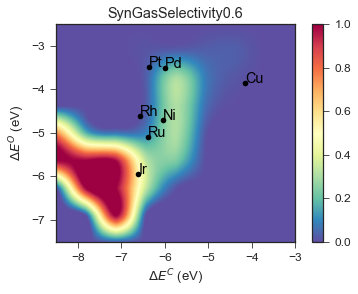

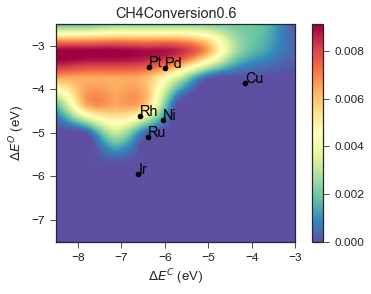

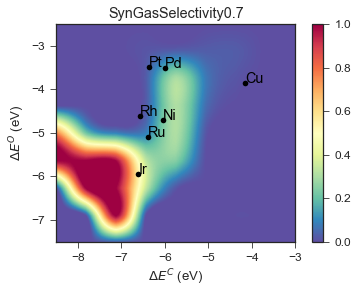

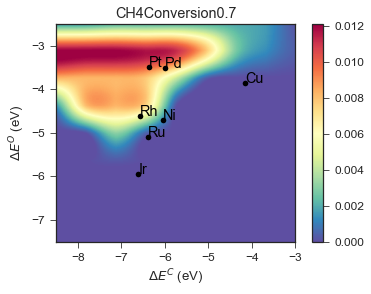

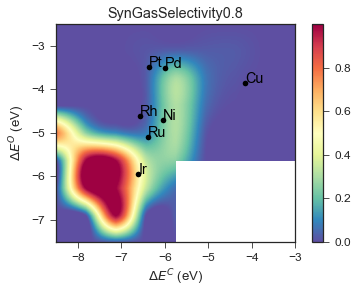

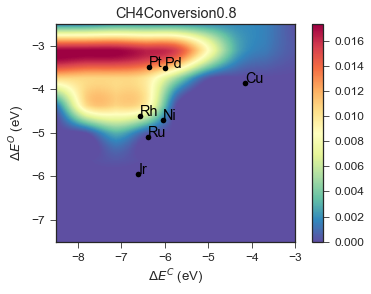

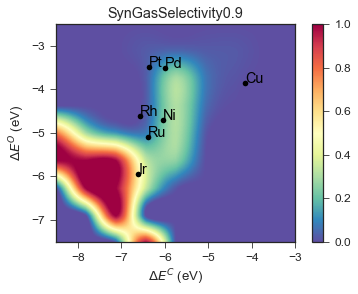

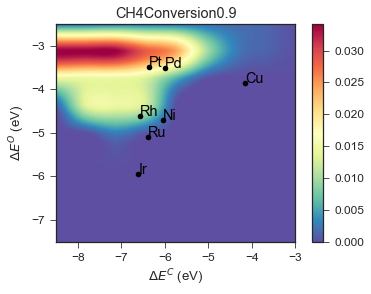

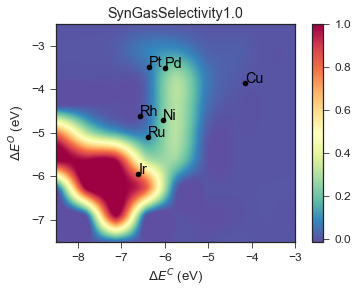

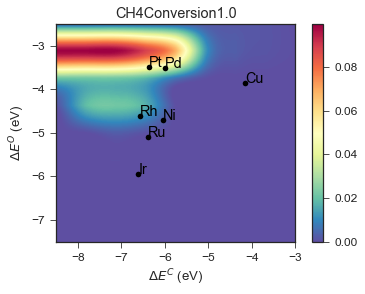

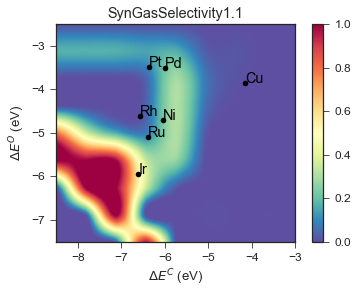

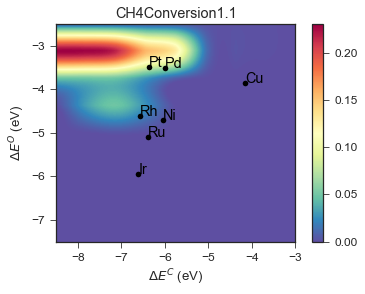

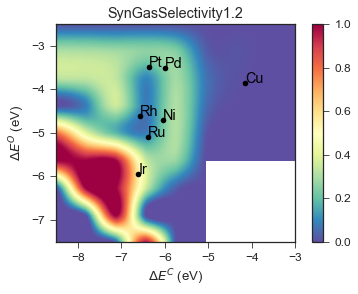

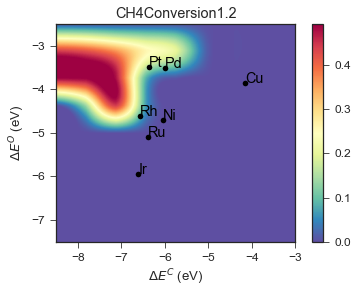

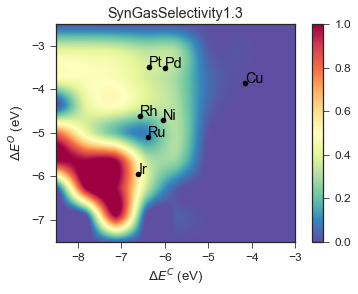

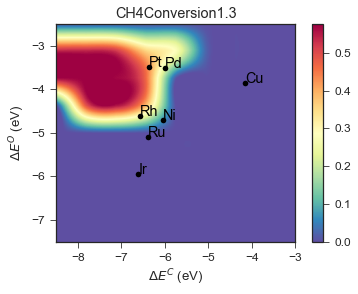

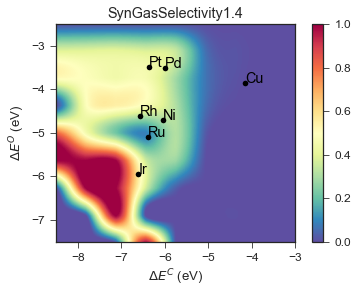

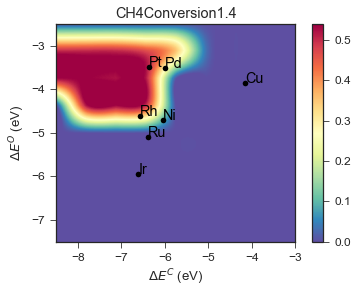

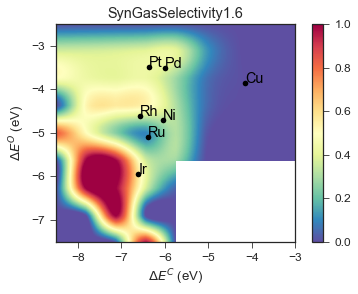

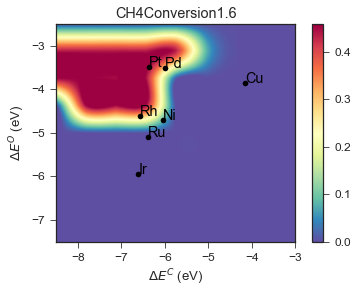

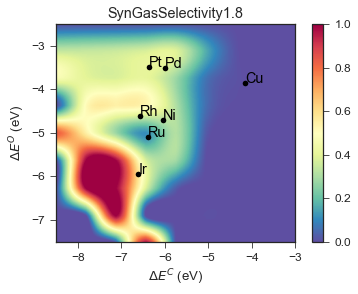

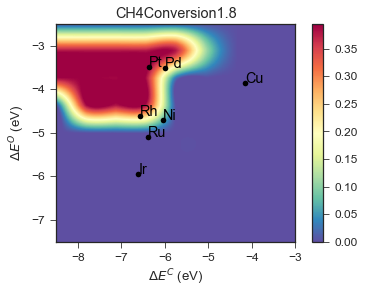

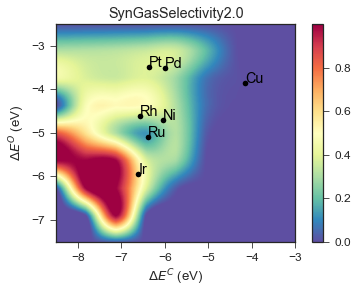

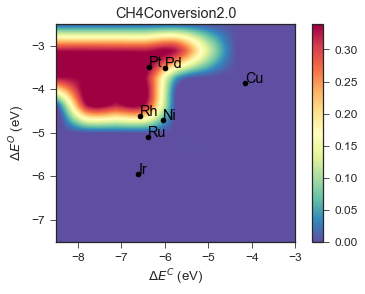

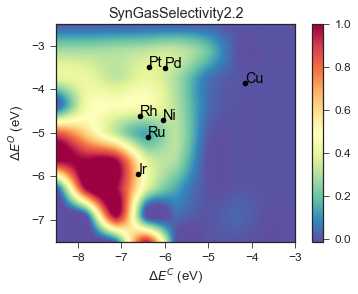

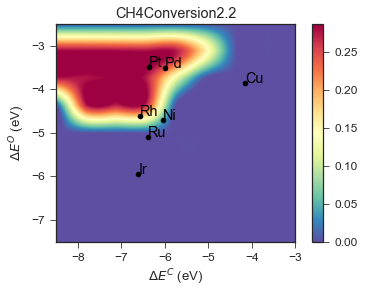

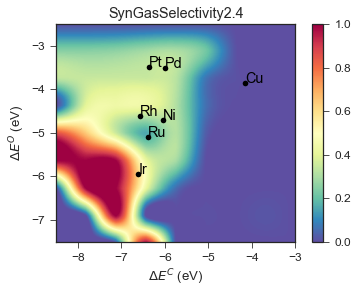

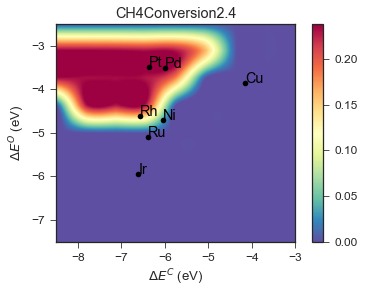

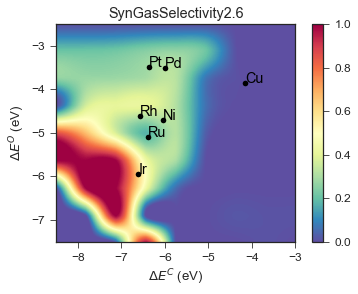

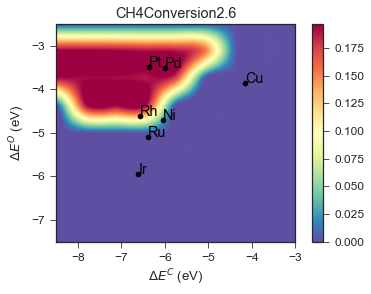

<Figure size 432x288 with 0 Axes>

In [19]:
# get lavaplots
for k in range(len(all_ratios)):
    g = synGasSelec[:,k]
    title = 'SynGasSelectivity'+ str(all_ratios[k])
    lavaPlot(g,title)
    
    h = ch4Conversion[:,k]
    title = 'CH4Conversion'+str(all_ratios[k])
    lavaPlot(h,title)

/Users/emilymazeau/anaconda2/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


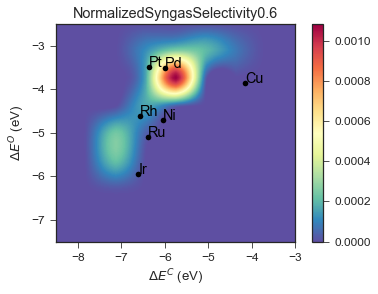

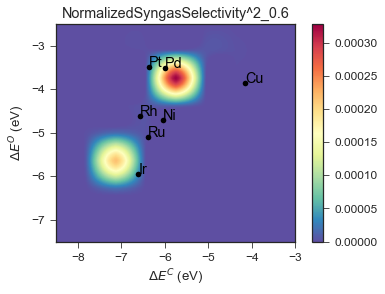

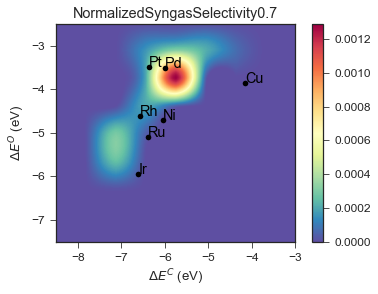

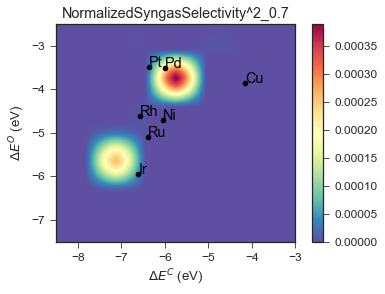

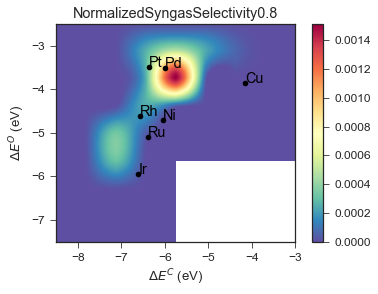

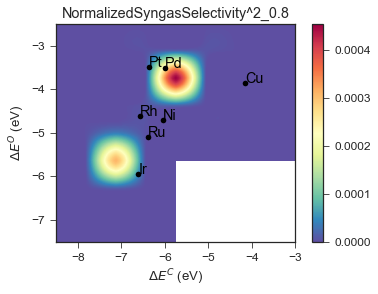

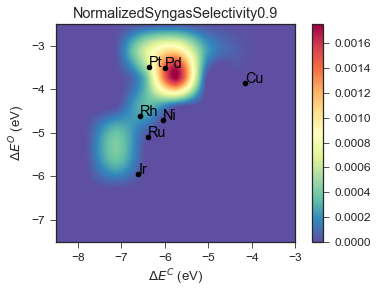

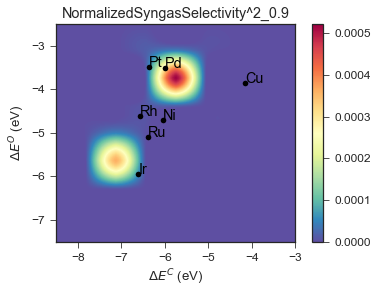

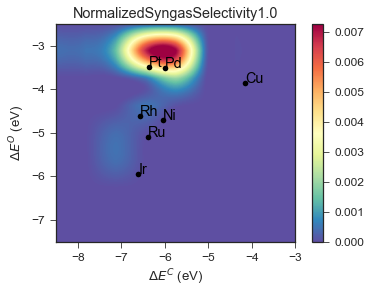

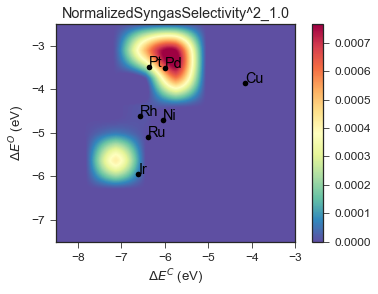

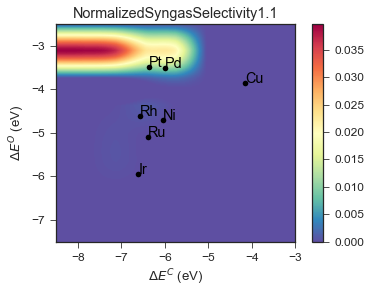

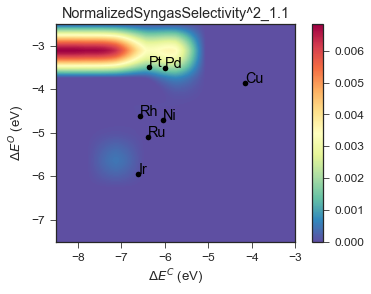

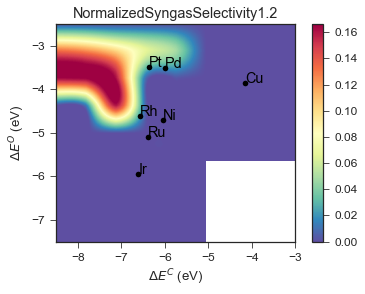

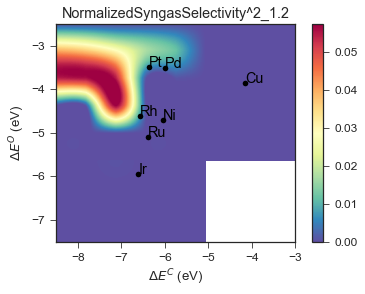

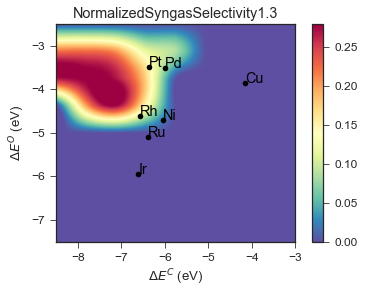

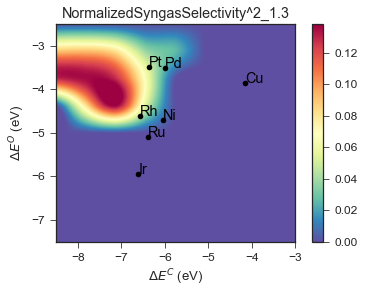

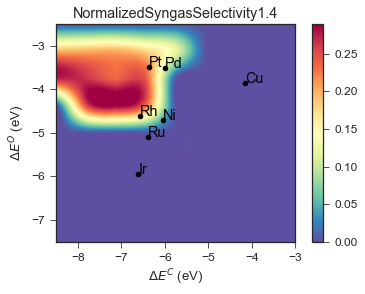

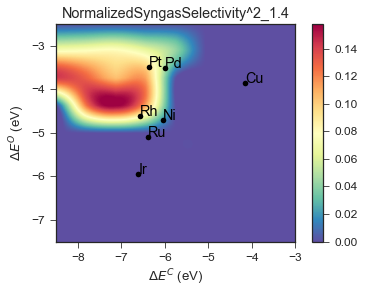

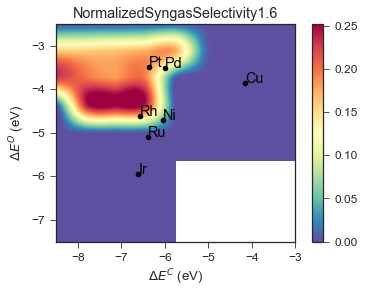

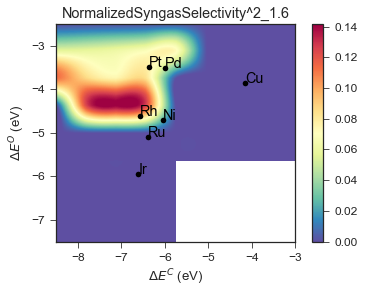

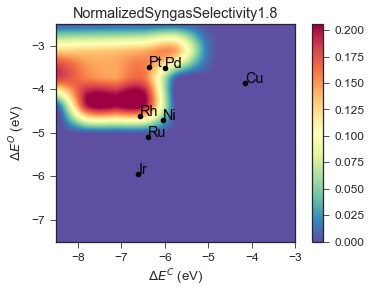

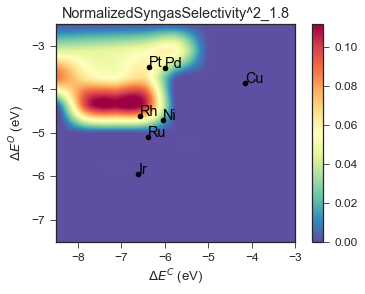

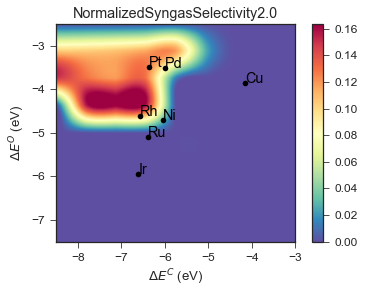

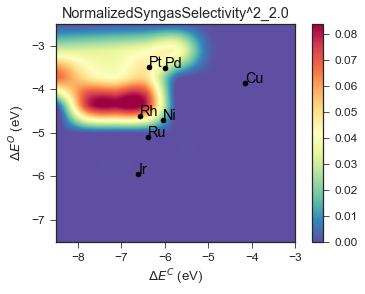

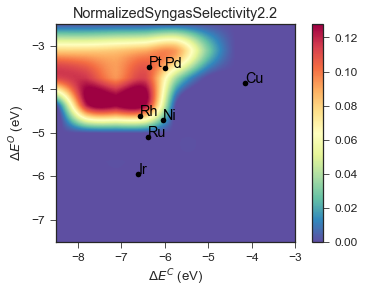

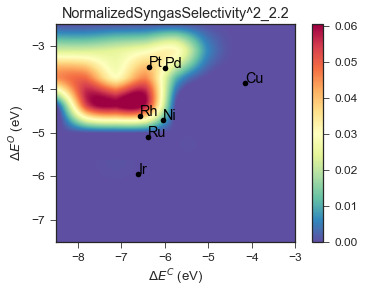

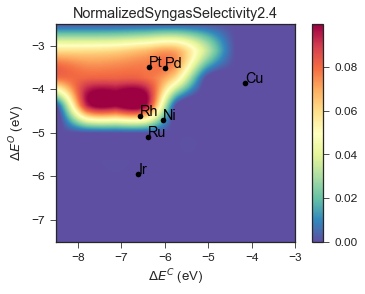

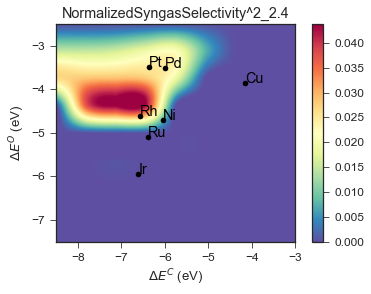

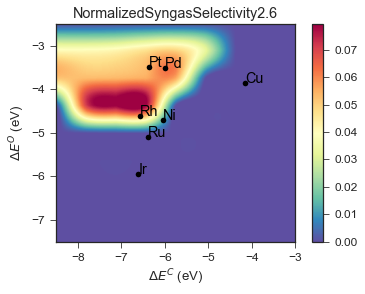

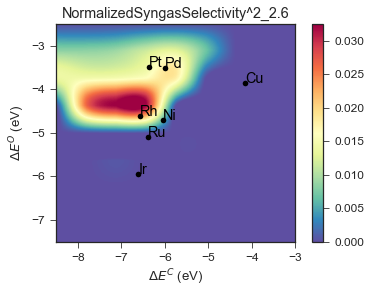

<Figure size 432x288 with 0 Axes>

In [34]:
# normalized lavaplot, syngas selectivity * ch4 conversion
normalized = np.multiply(synGasSelec,ch4Conversion)

# david's "efficiency?"
# ch4 conv * syn gas selectivity ^2
davidNormalized = np.multiply(normalized,synGasSelec) 

for k in range(len(all_ratios)):
    g = normalized[:,k]
    title = 'NormalizedSyngasSelectivity'+ str(all_ratios[k])
    lavaPlot(g,title)
    
    h = davidNormalized[:,k]
    title = 'NormalizedSyngasSelectivity^2_'+ str(all_ratios[k])
    lavaPlot(h,title)

In [67]:
def loadNumSurfRxns(folders):
    num_surf_reactions = []
    for x in folders:
        try:
            # load the sensitivities, default to 0.6 ratio and 1st def of sensitivity
            data = pd.read_csv('./linearscaling/' + x + '/dict_0.6ratio_1.csv', header=None)

            # get the reactions
            rxns = []
            n = []
            for y in data[1]:
                rxns.append(y)
            for y in data[2]:
                n.append([y])
            zipped = zip(rxns,n)
            zipped = [list(z) for z in zipped]
            #counting number of surface reactions in each 
            num_surf_reactions.append(len(zipped))
        except:
            print("Cannot load {}".format(x))
    return num_surf_reactions

def loadSens(folders,ratio,sens_def=1):
    reactions = [] # where the sensitivites are stored
    count = 1
    for x in folders:
        try:
            # load the sensitivities
            data = pd.read_csv('./linearscaling/' + x + '/dict_'+ str(ratio) + 'ratio_' + str(sens_def) + '.csv', header=None)

            # get the reactions
            rxns = []
            n = []
            for y in data[1]:
                rxns.append(y)
            for y in data[2]:
                n.append([y])
            zipped = zip(rxns,n)
            zipped = [list(z) for z in zipped]

            if count is 1:
                reactions = zipped
            else:
                # add the reactions that already have a match
                for rxn in reactions:
                    for a in zipped:
                        if a[0] == rxn[0]:
                            rxn[1].append(a[1][0])
                            zipped.remove(a)
                # add 0s to the reactions that don't occur in this model
                for f in reactions:
                    if len(f[1]) is not count:
                        f[1].append(1E-9)
                # add the new reactions
                for a in zipped:
                    if len(a[1]) is not count:
                        zeros = [1E-9] * (count - len(a[1]))
                        a[1] = zeros + a[1]
                        reactions.append(a)
            count += 1
        except:
            print("{} has no csv for ratio {} and sensitivity {}".format(x,ratio,s))
            if reactions == []:
                if count is 1:
                    reactions = [['placeholder',[1E-9]]]
            else:
                for f in reactions:
                    if len(f[1]) is not count:
                        f[1].append(1E-9)
            count += 1
    # delete the placeholder?
#     del reactions[0]
    return reactions

In [72]:
# load sensitivity csv files
array = os.listdir('./linearscaling/')
array = sorted(array)

sens_defs = [1,2,3]

rxn_num = loadNumSurfRxns(array)

for r in all_ratios:
    s1=[];s2=[];s3=[]
    for s in sens_defs:
        if s == 1:
            s1.append([r,loadSens(array,r,s)])
        if s == 2:
            s2.append([r,loadSens(array,r,s)])
        if s == 3:
            s3.append([r,loadSens(array,r,s)])

rxn_num = loadNumSurfRxns(array)

Cannot load c-3.000o-6.875
Cannot load c-3.000o-7.500
Cannot load c-3.688o-6.875
Cannot load c-3.688o-7.500
Cannot load c-4.375o-6.875
Cannot load c-4.375o-7.500
Cannot load c-5.062o-6.875
Cannot load c-5.062o-7.500
Cannot load c-5.750o-6.875
Cannot load c-5.750o-7.500
Cannot load c-6.438o-6.875
Cannot load c-6.438o-7.500
Cannot load c-7.125o-6.875
Cannot load c-7.125o-7.500
Cannot load c-7.812o-6.250
Cannot load c-7.812o-6.875
Cannot load c-7.812o-7.500
Cannot load c-8.500o-5.625
Cannot load c-8.500o-6.250
Cannot load c-8.500o-6.875
Cannot load c-8.500o-7.500
c-3.000o-6.875 has no csv for ratio 0.6 and sensitivity 1
c-3.000o-7.500 has no csv for ratio 0.6 and sensitivity 1
c-3.688o-6.875 has no csv for ratio 0.6 and sensitivity 1
c-3.688o-7.500 has no csv for ratio 0.6 and sensitivity 1
c-4.375o-6.875 has no csv for ratio 0.6 and sensitivity 1
c-4.375o-7.500 has no csv for ratio 0.6 and sensitivity 1
c-5.062o-6.875 has no csv for ratio 0.6 and sensitivity 1
c-5.062o-7.500 has no csv f

c-8.500o-5.625 has no csv for ratio 0.8 and sensitivity 1
c-8.500o-6.250 has no csv for ratio 0.8 and sensitivity 1
c-8.500o-6.875 has no csv for ratio 0.8 and sensitivity 1
c-8.500o-7.500 has no csv for ratio 0.8 and sensitivity 1
c-3.000o-6.875 has no csv for ratio 0.8 and sensitivity 2
c-3.000o-7.500 has no csv for ratio 0.8 and sensitivity 2
c-3.688o-6.875 has no csv for ratio 0.8 and sensitivity 2
c-3.688o-7.500 has no csv for ratio 0.8 and sensitivity 2
c-4.375o-6.875 has no csv for ratio 0.8 and sensitivity 2
c-4.375o-7.500 has no csv for ratio 0.8 and sensitivity 2
c-5.062o-6.875 has no csv for ratio 0.8 and sensitivity 2
c-5.062o-7.500 has no csv for ratio 0.8 and sensitivity 2
c-5.750o-6.875 has no csv for ratio 0.8 and sensitivity 2
c-5.750o-7.500 has no csv for ratio 0.8 and sensitivity 2
c-6.438o-3.750 has no csv for ratio 0.8 and sensitivity 2
c-6.438o-6.875 has no csv for ratio 0.8 and sensitivity 2
c-6.438o-7.500 has no csv for ratio 0.8 and sensitivity 2
c-7.125o-6.250

c-5.062o-6.875 has no csv for ratio 1.0 and sensitivity 3
c-5.062o-7.500 has no csv for ratio 1.0 and sensitivity 3
c-5.750o-6.875 has no csv for ratio 1.0 and sensitivity 3
c-5.750o-7.500 has no csv for ratio 1.0 and sensitivity 3
c-6.438o-6.875 has no csv for ratio 1.0 and sensitivity 3
c-6.438o-7.500 has no csv for ratio 1.0 and sensitivity 3
c-7.125o-7.500 has no csv for ratio 1.0 and sensitivity 3
c-7.812o-6.250 has no csv for ratio 1.0 and sensitivity 3
c-7.812o-6.875 has no csv for ratio 1.0 and sensitivity 3
c-7.812o-7.500 has no csv for ratio 1.0 and sensitivity 3
c-8.500o-5.625 has no csv for ratio 1.0 and sensitivity 3
c-8.500o-6.250 has no csv for ratio 1.0 and sensitivity 3
c-8.500o-6.875 has no csv for ratio 1.0 and sensitivity 3
c-8.500o-7.500 has no csv for ratio 1.0 and sensitivity 3
c-3.000o-6.875 has no csv for ratio 1.1 and sensitivity 1
c-3.000o-7.500 has no csv for ratio 1.1 and sensitivity 1
c-3.688o-6.875 has no csv for ratio 1.1 and sensitivity 1
c-3.688o-7.500

c-6.438o-6.875 has no csv for ratio 1.3 and sensitivity 1
c-6.438o-7.500 has no csv for ratio 1.3 and sensitivity 1
c-7.125o-7.500 has no csv for ratio 1.3 and sensitivity 1
c-7.812o-6.875 has no csv for ratio 1.3 and sensitivity 1
c-7.812o-7.500 has no csv for ratio 1.3 and sensitivity 1
c-8.500o-5.625 has no csv for ratio 1.3 and sensitivity 1
c-8.500o-6.250 has no csv for ratio 1.3 and sensitivity 1
c-8.500o-6.875 has no csv for ratio 1.3 and sensitivity 1
c-8.500o-7.500 has no csv for ratio 1.3 and sensitivity 1
c-3.000o-6.875 has no csv for ratio 1.3 and sensitivity 2
c-3.000o-7.500 has no csv for ratio 1.3 and sensitivity 2
c-3.688o-6.875 has no csv for ratio 1.3 and sensitivity 2
c-3.688o-7.500 has no csv for ratio 1.3 and sensitivity 2
c-4.375o-6.875 has no csv for ratio 1.3 and sensitivity 2
c-4.375o-7.500 has no csv for ratio 1.3 and sensitivity 2
c-5.062o-6.875 has no csv for ratio 1.3 and sensitivity 2
c-5.062o-7.500 has no csv for ratio 1.3 and sensitivity 2
c-5.750o-6.875

c-6.438o-6.875 has no csv for ratio 1.6 and sensitivity 3
c-6.438o-7.500 has no csv for ratio 1.6 and sensitivity 3
c-7.125o-7.500 has no csv for ratio 1.6 and sensitivity 3
c-7.812o-5.625 has no csv for ratio 1.6 and sensitivity 3
c-7.812o-6.875 has no csv for ratio 1.6 and sensitivity 3
c-7.812o-7.500 has no csv for ratio 1.6 and sensitivity 3
c-8.500o-5.625 has no csv for ratio 1.6 and sensitivity 3
c-8.500o-6.250 has no csv for ratio 1.6 and sensitivity 3
c-8.500o-6.875 has no csv for ratio 1.6 and sensitivity 3
c-8.500o-7.500 has no csv for ratio 1.6 and sensitivity 3
c-3.000o-6.875 has no csv for ratio 1.8 and sensitivity 1
c-3.000o-7.500 has no csv for ratio 1.8 and sensitivity 1
c-3.688o-6.875 has no csv for ratio 1.8 and sensitivity 1
c-3.688o-7.500 has no csv for ratio 1.8 and sensitivity 1
c-4.375o-6.875 has no csv for ratio 1.8 and sensitivity 1
c-4.375o-7.500 has no csv for ratio 1.8 and sensitivity 1
c-5.062o-6.875 has no csv for ratio 1.8 and sensitivity 1
c-5.062o-7.500

c-7.125o-7.500 has no csv for ratio 2.2 and sensitivity 1
c-7.812o-6.875 has no csv for ratio 2.2 and sensitivity 1
c-7.812o-7.500 has no csv for ratio 2.2 and sensitivity 1
c-8.500o-5.625 has no csv for ratio 2.2 and sensitivity 1
c-8.500o-6.250 has no csv for ratio 2.2 and sensitivity 1
c-8.500o-6.875 has no csv for ratio 2.2 and sensitivity 1
c-8.500o-7.500 has no csv for ratio 2.2 and sensitivity 1
c-3.000o-6.875 has no csv for ratio 2.2 and sensitivity 2
c-3.000o-7.500 has no csv for ratio 2.2 and sensitivity 2
c-3.688o-6.875 has no csv for ratio 2.2 and sensitivity 2
c-3.688o-7.500 has no csv for ratio 2.2 and sensitivity 2
c-4.375o-6.875 has no csv for ratio 2.2 and sensitivity 2
c-4.375o-7.500 has no csv for ratio 2.2 and sensitivity 2
c-5.062o-6.875 has no csv for ratio 2.2 and sensitivity 2
c-5.062o-7.500 has no csv for ratio 2.2 and sensitivity 2
c-5.750o-6.875 has no csv for ratio 2.2 and sensitivity 2
c-5.750o-7.500 has no csv for ratio 2.2 and sensitivity 2
c-6.438o-6.875

c-6.438o-6.875 has no csv for ratio 2.6 and sensitivity 3
c-6.438o-7.500 has no csv for ratio 2.6 and sensitivity 3
c-7.125o-7.500 has no csv for ratio 2.6 and sensitivity 3
c-7.812o-6.875 has no csv for ratio 2.6 and sensitivity 3
c-7.812o-7.500 has no csv for ratio 2.6 and sensitivity 3
c-8.500o-5.625 has no csv for ratio 2.6 and sensitivity 3
c-8.500o-6.250 has no csv for ratio 2.6 and sensitivity 3
c-8.500o-6.875 has no csv for ratio 2.6 and sensitivity 3
c-8.500o-7.500 has no csv for ratio 2.6 and sensitivity 3
Cannot load c-3.000o-6.875
Cannot load c-3.000o-7.500
Cannot load c-3.688o-6.875
Cannot load c-3.688o-7.500
Cannot load c-4.375o-6.875
Cannot load c-4.375o-7.500
Cannot load c-5.062o-6.875
Cannot load c-5.062o-7.500
Cannot load c-5.750o-6.875
Cannot load c-5.750o-7.500
Cannot load c-6.438o-6.875
Cannot load c-6.438o-7.500
Cannot load c-7.125o-6.875
Cannot load c-7.125o-7.500
Cannot load c-7.812o-6.250
Cannot load c-7.812o-6.875
Cannot load c-7.812o-7.500
Cannot load c-8.500

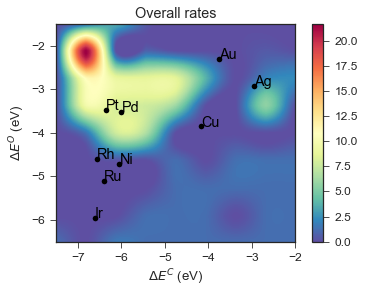

In [7]:
# df = pd.DataFrame(index=np.unique(o_s), columns=np.unique(c_s))
# for c, o, t in zip(c_s, o_s, times):
#     df[c][o] = t
    
# a = []
# for i in df.values: 
#     a = a + list(i)

# times = np.array(times)
# rates = 1./np.array(a)

# rates_grid = np.reshape(rates, (grid_size,grid_size))

# #ax = sns.heatmap(sensitivities_grid, cmap="Spectral")

# plt.imshow(rates_grid, interpolation='spline16', origin='lower', 
#            extent=extent2, aspect='equal', cmap="Spectral_r",)
# for metal, coords in abildpedersen_energies.iteritems():
#     color = {'Ag':'k','Au':'k','Cu':'k'}.get(metal,'k')
#     plt.plot(coords[0], coords[1], 'o'+color)
#     plt.text(coords[0], coords[1], metal, color=color)
# plt.xlim(carbon_range)
# plt.ylim(oxygen_range)
# plt.xlabel('$\Delta E^C$ (eV)')
# plt.ylabel('$\Delta E^O$ (eV)')
# plt.title("Overall rates")
# plt.colorbar()
# plt.show()

# #matplotlib.rcParams['figure.figsize'] = [10, 10]
# # matplotlib.rcParams['figure.titlesize']
# #matplotlib.rcParams['figure.dpi'] = 500

In [9]:
def sensPlots(reactions):
    for rxn in reactions:
        sensitivities = rxn[1]

        sensitivities = np.array(sensitivities)
        if sum(abs(sensitivities)>1e-9) < 5:
            print "skipping {} because it's boring".format(rxn[0])
            continue
        MAX = 5
        #log_sensitivities = np.log10(abs(sensitivities))
        #a = np.log10(abs(sensitivities)) + MAX
        #log_sensitivities = a * (a>0) * (1-2*(sensitivities<0) )
        df = pd.DataFrame(index=np.unique(o_s), columns=np.unique(c_s))
        for c, o, s in zip(c_s, o_s, sensitivities):
            df[c][o] = s

        a = []
        for i in df.values: 
            a = a + list(i)

        sensitivities = np.array(a)

        sensitivities_grid = np.reshape(sensitivities, (grid_size,grid_size))

        #ax = sns.heatmap(sensitivities_grid, cmap="Spectral")
        MAX = np.max(abs(sensitivities_grid))
        plt.imshow(sensitivities_grid, interpolation='spline16', origin='lower', 
                   extent=extent2, aspect='equal', cmap="Spectral_r",
                  vmin=-1*MAX, vmax=MAX)
        for metal, coords in abildpedersen_energies.iteritems():
            color = {'Ag':'k','Au':'k','Cu':'k'}.get(metal,'k')
            plt.plot(coords[0], coords[1], 'o'+color)
            plt.text(coords[0], coords[1], metal, color=color)
        plt.xlim(carbon_range)
        plt.ylim(oxygen_range)
        plt.xlabel('$\Delta E^C$ (eV)')
        plt.ylabel('$\Delta E^O$ (eV)')
        plt.title(rxn[0])
        plt.colorbar()
        plt.show()

        #matplotlib.rcParams['figure.dpi'] = 500
    


In [9]:
# Plot the number of surface reactions
# num_surf_reactions

# reaction_counts_grid = np.log10(np.reshape(num_surf_reactions, (grid_size,grid_size)))
# plt.imshow(reaction_counts_grid.T, interpolation='none', origin='lower', extent=extent2, aspect='equal')
# plt.xlim(carbon_range2)
# plt.ylim(oxygen_range2)
# plt.xlabel('$\Delta E^C$ (eV)')
# plt.ylabel('$\Delta E^O$ (eV)')
# for e,n in zip(experiments,num_surf_reactions):
#     plt.text(e[0],e[1],n,color='w',ha='center', va='center')
# plt.colorbar()

In [10]:
# A linear one, just to check it looks the same
# reaction_counts_grid = np.reshape(num_surf_reactions, (grid_size,grid_size))
# ax = sns.heatmap(reaction_counts_grid.T[::-1,:], annot=True, fmt='d', square=True)